In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample
from optic.utils import parameters

# Cálculo da Densidade Espectral de Potência (DSP) de um Sinal em Banda Base

Este texto apresenta o cálculo da densidade espectral de potência (DSP) de um sinal modulador em banda base. Assumem-se símbolos independentes, equiprováveis e de média nula.

---

## Modelo do Sinal PAM em Banda Base

O sinal transmitido é modelado como:

$$
s(t) = \sum_{k=-\infty}^{\infty} a_k\, p(t - kT)
$$

onde:

- $a_k$ são símbolos transmitidos (variáveis aleatórias),
- $p(t)$ é o formato de pulso,
- $T$ é o tempo de símbolo.

Assumimos:

$$
\mathbb{E}[a_k] = 0,
\qquad
\mathbb{E}[a_k^2] = \sigma_a^2
$$

Os símbolos são independentes, portanto a autocorrelação discreta é:

$$
R_a[m] = \mathbb{E}[a_k\, a_{k+m}] =
\begin{cases}
\sigma_a^2, & m = 0 \\
0, & m \neq 0
\end{cases}
$$

A DSP da sequência discreta de símbolos é:

$$
S_a(f) = \frac{\sigma_a^2}{T}.
$$


## DSP do Sinal Transmitido

Como o sinal é gerado pela convolução da sequência com o pulso $p(t)$, o teorema de modulação de processos aleatórios fornece:

$$
S_s(f) = S_a(f)\, |P(f)|^2.
$$

Substituindo, obtém-se a expressão geral da DSP de um sinal modulado digitalmente transmitido em banda base:

$$
S_s(f) = \frac{\sigma_a^2}{T}\, |P(f)|^2.
$$

---

## Exemplo: Pulso Retangular

Considere o pulso

$$
p(t) = A, \quad 0 \le t \le T,
$$

que pode ser escrit na forma

$$
p(t) = A\,[u(t) - u(t - T)].
$$

Aplicando-se a transformada de Fourier, obtem-se

$$
P(f) = A\,T\, \mathrm{sinc}(fT)\, e^{-j\pi fT},
$$

e

$$
|P(f)|^2 = A^2 T^2\, \mathrm{sinc}^2(fT).
$$

Assim, a DSP resultante é dada por

$$
S_s(f) = \sigma_a^2\, A^2 T\, \mathrm{sinc}^2(fT).
$$

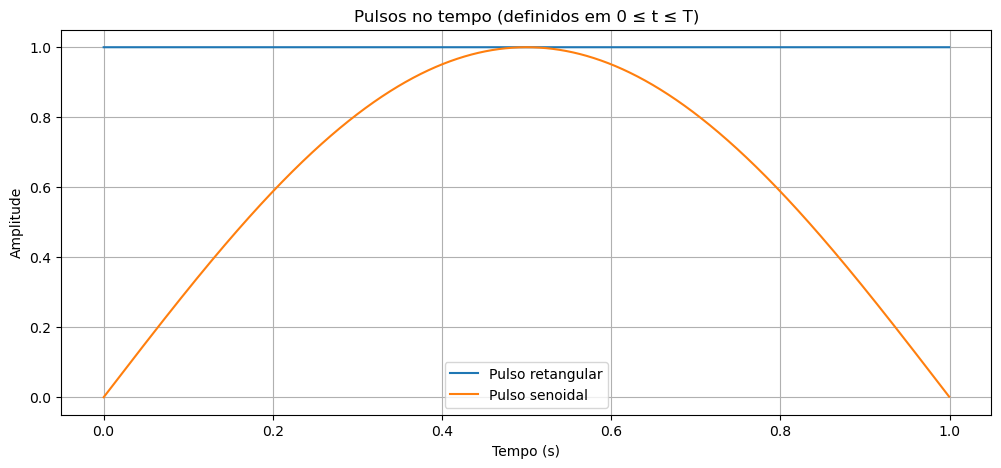

In [8]:
#----------------------------------------------------------------------------------
# Código que obtém e exibe a DSP de dois sinais com modulação PSK para dois pulsos:
# a) Retangular
# b) A*sin(πt/T)
#----------------------------------------------------------------------------------
        
N = 4096
fs = 2000
T = 1      

# Definição dos pulsos
t = np.linspace(0, T, int(T*fs), endpoint=False)
p_rect = np.ones_like(t)
p_sin = np.sin(np.pi * t / T)

plt.figure(figsize=(12,5))
plt.plot(t, p_rect, label='Pulso retangular')
plt.plot(t, p_sin, label='Pulso senoidal')
plt.title("Pulsos no tempo (definidos em 0 ≤ t ≤ T)")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()

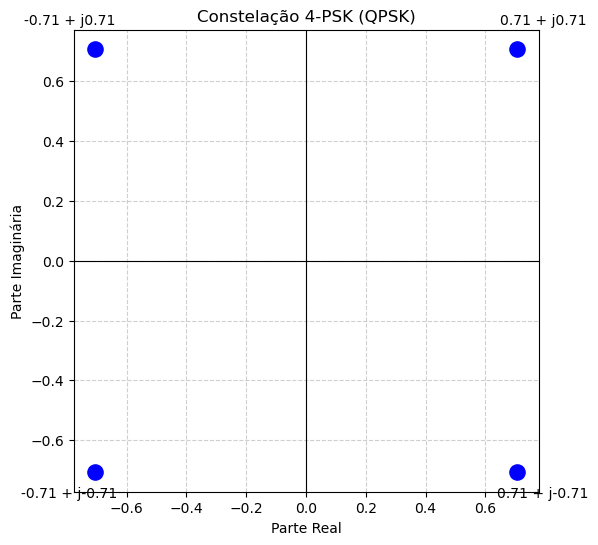

In [9]:
# Símbolos modulsação 4-PSK
symbols = (1/np.sqrt(2)) * np.array([1+1j, 1-1j, -1+1j, -1-1j])
ak = np.random.choice(symbols, 1000)

plt.figure(figsize=(6,6))
plt.scatter(np.real(symbols), np.imag(symbols), s=120, color='blue')

for s in symbols:
    plt.text(np.real(s)*1.12, np.imag(s)*1.12,
             f"{np.real(s):.2f} + j{np.imag(s):.2f}",
             fontsize=10, ha="center")

plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("Constelação 4-PSK (QPSK)")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginária")
plt.axis('equal')
plt.show()

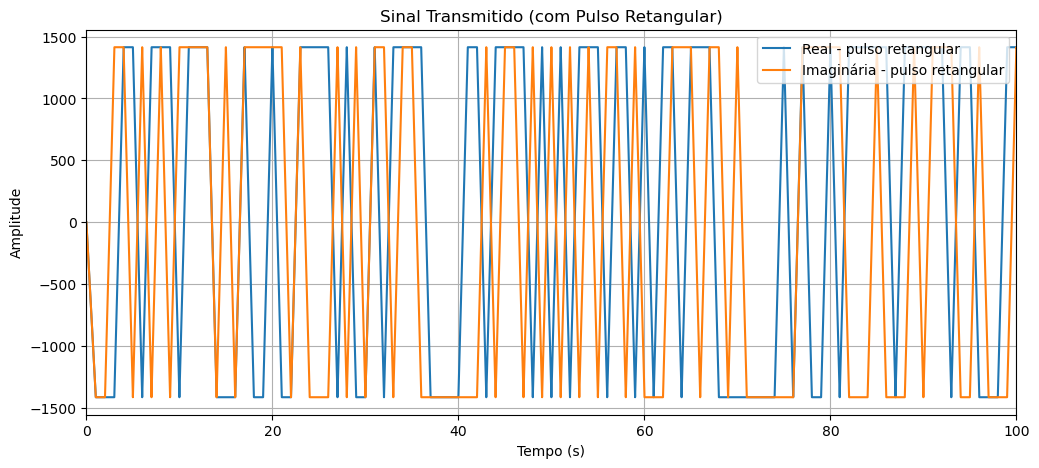

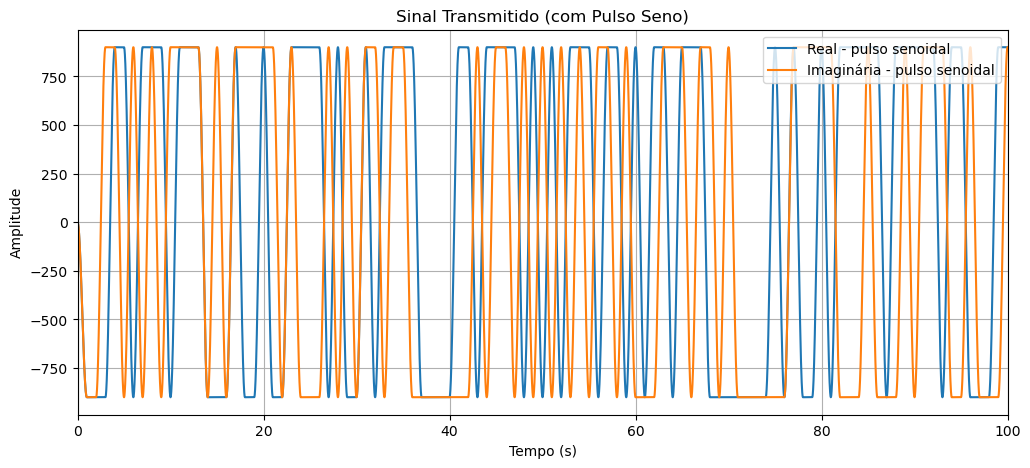

In [11]:
# Formatação de pulso
ak_up = np.repeat(ak, len(t))
s_rect = np.convolve(ak_up, p_rect, mode='full')
s_sin  = np.convolve(ak_up, p_sin, mode='full')
t_sig = np.arange(len(s_rect)) / fs

plt.figure(figsize=(12,5))
plt.plot(t_sig, np.real(s_rect), label='Real - pulso retangular')
plt.plot(t_sig, np.imag(s_rect), label='Imaginária - pulso retangular')
plt.title("Sinal Transmitido (com Pulso Retangular)")
plt.xlim(0, 100)
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc ='upper right')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(t_sig, np.real(s_sin), label='Real - pulso senoidal')
plt.plot(t_sig, np.imag(s_sin), label='Imaginária - pulso senoidal')
plt.title("Sinal Transmitido (com Pulso Seno)")
plt.xlim(0, 100)
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

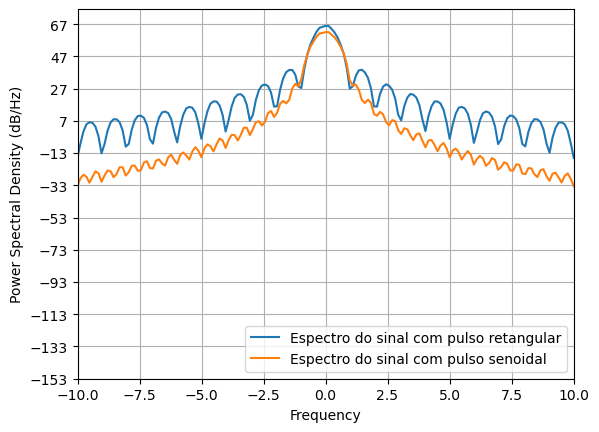

In [14]:
sigTx = firFilter(p_rect, ak_up)
sigTx_sin = firFilter(p_sin, ak_up)


# plota psd
plt.figure()
plt.xlim(-10,10)
plt.psd(sigTx,Fs=fs, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal com pulso retangular')
plt.psd(sigTx_sin,Fs=fs, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal com pulso senoidal')
plt.legend(loc = 'lower right')